<a href="https://colab.research.google.com/github/ApoorvaNagarajan/Image-Filter-Kernels/blob/master/assignment9/assignment9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import all the required python libraries

from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
import cv2

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10

# downloads the CIFAR10 dataset and splits it into test and train.
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()


# calculate the dimensions and number of classes
num_train, img_rows, img_cols, img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


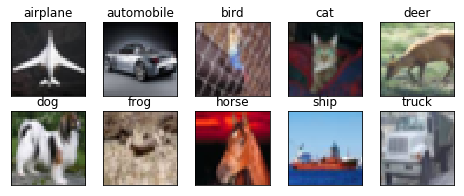

In [3]:
# gallery to display 1 image from each of the classes

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
# function to plot loss and accuracy of the network

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
# function to calculate test accuacy

def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
#pixel normalization of test and train data
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [7]:
modelNew = Sequential()

modelNew.add(Convolution2D(64, 3, 3, border_mode='same', input_shape=(32,32,3))) # RF: 3x3, output dim: 32x32x48
modelNew.add(BatchNormalization())
modelNew.add(Activation('relu'))
modelNew.add(Dropout(0.15))

modelNew.add(Convolution2D(128, 3, 3, border_mode='same')) # RF: 5x5, output dim: 32x32x48
modelNew.add(BatchNormalization())
modelNew.add(Activation('relu'))
modelNew.add(Dropout(0.15))

modelNew.add(Convolution2D(256, 3, 3)) # RF: 7x7, output dim: 30x30x48
modelNew.add(BatchNormalization())
modelNew.add(Activation('relu'))
modelNew.add(Dropout(0.15))

modelNew.add(Convolution2D(64, 1, 1, activation='relu')) # RF: 7x7, output dim: 30x30x64
modelNew.add(MaxPooling2D(pool_size=(2, 2))) # RF: 14x14, output dim: 15x15x96
modelNew.add(Dropout(0.15))

modelNew.add(Convolution2D(64, 3, 3, border_mode='same')) # RF: 16x16, output dim: 15x15x64
modelNew.add(BatchNormalization())
modelNew.add(Activation('relu'))
modelNew.add(Dropout(0.15))

modelNew.add(Convolution2D(128, 3, 3, border_mode='same')) # RF: 18x18, output dim: 15x15x128
modelNew.add(BatchNormalization())
modelNew.add(Activation('relu'))
modelNew.add(Dropout(0.15))

modelNew.add(Convolution2D(256, 3, 3)) # RF: 20x20, output dim: 13x13x256
modelNew.add(BatchNormalization())
modelNew.add(Activation('relu'))
modelNew.add(Dropout(0.15))

modelNew.add(Convolution2D(64, 1, 1, activation='relu')) # RF: 20x20, output dim: 13x13x64
modelNew.add(MaxPooling2D(pool_size=(2, 2))) # RF: 40x40, output dim: 6x6x64
modelNew.add(Dropout(0.15))

modelNew.add(Convolution2D(64, 3, 3, border_mode='same')) # RF: 42x42, output dim: 6x6x64
modelNew.add(BatchNormalization())
modelNew.add(Activation('relu'))
modelNew.add(Dropout(0.15))

modelNew.add(Convolution2D(128, 3, 3, border_mode='same')) # RF: 44x44, output dim: 6x6x128
modelNew.add(BatchNormalization())
modelNew.add(Activation('relu'))
modelNew.add(Dropout(0.15))

modelNew.add(Convolution2D(256, 3, 3)) # RF: 46x46, output dim: 4x4x256
modelNew.add(BatchNormalization())
modelNew.add(Activation('relu'))


modelNew.add(Convolution2D(num_classes, 1, 1, activation='relu')) # RF: 46x46, output dim: 4x4x10
modelNew.add(Convolution2D(num_classes, 4, 4))


modelNew.add(Flatten())
modelNew.add(Activation('softmax'))


modelNew.summary()

W0628 02:47:09.448822 140085806655360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
W0628 02:47:09.485510 140085806655360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0628 02:47:09.491152 140085806655360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0628 02:47:09.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 128)       0         
__________

In [0]:
# Load the saved model of assignment 6a
modelNew.load_weights("assign6a_model");
preds = modelNew.predict(train_features)


In [0]:
def gradCam(pred, x, model):
  class_idx = np.argmax(pred)
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("conv2d_12")
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(10):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (32,32))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  img = np.uint8(255 * x.reshape(32,32,3))
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  return(img,superimposed_img)
  

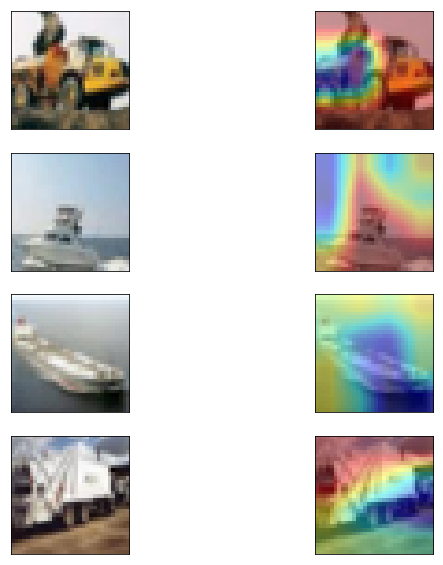

In [53]:
in_img1, sup_img1 = gradCam(preds[270],train_features[270:271],modelNew)
in_img2, sup_img2 = gradCam(preds[100],train_features[100:101],modelNew)
in_img3, sup_img3 = gradCam(preds[2003],train_features[2003:2004],modelNew)
in_img4, sup_img4 = gradCam(preds[512],train_features[512:513],modelNew)
 
fig = plt.figure(figsize=(10,10))

fig.add_subplot(4, 2, 1, xticks=[], yticks=[])
plt.imshow(in_img1)

fig.add_subplot(4, 2, 2, xticks=[], yticks=[])
plt.imshow(sup_img1)


fig.add_subplot(4, 2, 3, xticks=[], yticks=[])
plt.imshow(in_img2)

fig.add_subplot(4, 2, 4, xticks=[], yticks=[])
plt.imshow(sup_img2)


fig.add_subplot(4, 2, 5, xticks=[], yticks=[])
plt.imshow(in_img3)

fig.add_subplot(4, 2, 6, xticks=[], yticks=[])
plt.imshow(sup_img3)

fig.add_subplot(4, 2, 7, xticks=[], yticks=[])
plt.imshow(in_img4)

fig.add_subplot(4, 2, 8, xticks=[], yticks=[])
plt.imshow(sup_img4)

plt.show()


In [0]:
# Add cutout and train the network